## Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

In [1]:
%matplotlib inline

from sklearn import svm
from tensorflow.keras.utils import get_file
import os
import gensim
import numpy as np
import random
import requests
import geopandas as gpd
#from IPython.core.pylabtools import figsize
import csv

import matplotlib.pyplot
matplotlib.pyplot.rcParams['figure.figsize'] = (12, 8)

as before, let's load up the model

In [2]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

Most similar to a bunch of countries are some other countries!

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)
model.most_similar(positive=['Germany'])

/home/mitsuhisa.ohta/.pyenv/versions/3.6.7/envs/deep_learning_cookbook/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Austria', 0.7461064457893372),
 ('German', 0.717875063419342),
 ('Germans', 0.6628649830818176),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.6493481993675232),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.634294867515564)]

In [4]:
# unused in the book
model.most_similar(positive=['Annita_Kirsten'])

[('Braustolz_GmbH', 0.7545096278190613),
 ('DIARY_Economic_Indicators', 0.7334566712379456),
 ('##-##_#####_Burscheid', 0.7307889461517334),
 ('WKN_A#N#Y#_Symbol', 0.7260338664054871),
 ('Hoevelaken', 0.706748902797699),
 ('BMW_###si_1min_##.###secs', 0.7050351500511169),
 ('Primera_EUROPE', 0.6997409462928772),
 ('symbol_RSTI', 0.6925468444824219),
 ('Severin_Freund', 0.689895749092102),
 ('However_Joern_Lauterjung', 0.688573956489563)]

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [22]:
countries

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
 OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
 OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')]),
 OrderedDict([('name', 'Tanzania'), ('cc', 'tz'), ('cc3', 'tza')]),
 OrderedDict([('name', 'Monaco'), ('cc', 'mc'), ('cc3', 'mco')]),
 OrderedDict([('name', 'Svalbard'), ('cc', 'sj'), ('cc3', 'sjm')]),
 OrderedDict([('name', 'Tajikistan'), ('cc', 'tj'), ('cc3', 'tjk')]),
 OrderedDict([('name', 'Turkey'), ('cc',

In [5]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:10]

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
 OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
 OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')])]

In [6]:
positive = [x['name'] for x in random.sample(countries, 40)]
positive

['Tajikistan',
 'England',
 'Luxembourg',
 'Ukraine',
 'Oman',
 'Romania',
 'Western_Sahara',
 'Afghanistan',
 'Uzbekistan',
 'Bhutan',
 'Argentina',
 'Mauritius',
 'Austria',
 'Niger',
 'Mongolia',
 'Kyrgyzstan',
 'France',
 'Denmark',
 'North_Korea',
 'Russia',
 'Taiwan',
 'Norway',
 'Gabon',
 'Eritrea',
 'Thailand',
 'Brazil',
 'El_Salvador',
 'Togo',
 'Solomon_Islands',
 'Philippines',
 'Zambia',
 'Chile',
 'Slovenia',
 'Lesotho',
 'Colombia',
 'Macedonia',
 'Senegal',
 'Burundi',
 'Bahamas',
 'Congo']

In [7]:
negative = random.sample(model.vocab.keys(), 5000)
negative[:4]

['Taking_suo_motu_cognizance',
 'Aryaloka_Buddhist_Center',
 'RUSSELL_CONTRERAS',
 'Cinnamon_Sticks']

In [8]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
x = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
x.shape, y.shape

((5040, 300), (5040,))

In [9]:
TRAINING_FRACTION = 0.7
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(x[:cut_off], y[:cut_off]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

We did alright, 99.9% accuracy:

In [10]:
res = clf.predict(x[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.86772486772487, [('Western_Sahara', 1), ('Afghanistan', 1)])

In [11]:
all_predictions = clf.predict(model.syn0)

/home/mitsuhisa.ohta/.pyenv/versions/3.6.7/envs/deep_learning_cookbook/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [28]:
res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
random.sample(res, 10)

['Cambodia',
 'Turkmenistan',
 'St._Kitts_Nevis',
 'Singapore',
 'Grenadines',
 'Tokelau',
 'Uruguayans',
 'ex_Soviet',
 'Unites_States',
 'Azores']

In [34]:
# そもそもの目的だった、 Germany と近い「国」だけを抽出できるかを確認するために追加
# German や Germnay（Typo）、Cologne（ケルン、都市名）symbol_RSTI などを排除できている
for candidate, similarity in model.most_similar(positive=['Germany']):
    print(candidate, clf.predict([model[candidate]]))

/home/mitsuhisa.ohta/.pyenv/versions/3.6.7/envs/deep_learning_cookbook/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Austria [1]
German [0]
Germans [0]
Switzerland [1]
Hungary [1]
Germnay [0]
Netherlands [1]
Cologne [0]
symbol_RSTI [0]
Annita_Kirsten [0]


In [13]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

Quick sanity check to see what is similar to Canada:

In [14]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.5440235
New_Zealand 3.9619699
Finland 3.9392405
Puerto_Rico 3.8381448
Jamaica 3.8102937
Sweden 3.8042784
Slovakia 3.7038736
Australia 3.6711009
Bahamas 3.624042
United_States 3.5374334


In [39]:
country_names = [c['name'] for c in countries]

In [36]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    dists = model.distances()
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

/home/mitsuhisa.ohta/.pyenv/versions/3.6.7/envs/deep_learning_cookbook/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.947881106287241

In [44]:
sorted(zip(model.distances('cricket', country_names), country_names))

[(0.51869583, 'Sri_Lanka'),
 (0.56798124, 'Bangladesh'),
 (0.5698657, 'Pakistan'),
 (0.5983279, 'Zimbabwe'),
 (0.61838317, 'India'),
 (0.6440878, 'South_Africa'),
 (0.65266395, 'England'),
 (0.6678935, 'New_Zealand'),
 (0.6698092, 'Guyana'),
 (0.6729771, 'Barbados'),
 (0.6830441, 'Australia'),
 (0.73723435, 'Fiji'),
 (0.7526635, 'Jamaica'),
 (0.75346446, 'Nepal'),
 (0.7737006, 'Kenya'),
 (0.77988577, 'Bhutan'),
 (0.78259397, 'Bermuda'),
 (0.7887111, 'Maldives'),
 (0.794703, 'Solomon_Islands'),
 (0.7971963, 'Mauritius'),
 (0.80042017, 'Malawi'),
 (0.8027637, 'Zambia'),
 (0.807386, 'Namibia'),
 (0.8078234, 'Uganda'),
 (0.80827963, 'Tonga'),
 (0.80912477, 'Ireland'),
 (0.81172353, 'Lesotho'),
 (0.8138555, 'East_Timor'),
 (0.81550896, 'Samoa'),
 (0.81688166, 'Botswana'),
 (0.82261443, 'Togo'),
 (0.82720786, 'Papua'),
 (0.8273457, 'UAE'),
 (0.8297128, 'Malaysia'),
 (0.83715844, 'Oman'),
 (0.8411744, 'Afghanistan'),
 (0.84248984, 'Swaziland'),
 (0.84317446, 'Bahrain'),
 (0.8458435, 'Nigeria'

Ranking countries for a specific term:

In [15]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [16]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.1924896240234375),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162840843200684),
 ('Barbados', 3.7579941749572754),
 ('India', 3.7504396438598633),
 ('South_Africa', 3.6561503410339355),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

Now let's visualize this on a world map:

In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


We can now plot some maps!

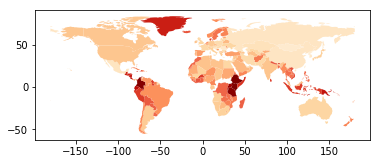

In [18]:
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

map_term('coffee')